In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [2]:
df = pd.read_csv(
    "data.csv", dtype={"CustomerID": str, "InvoiceNo": str}, parse_dates=["InvoiceDate"]
)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


# Feature Extraction: RFM Analysis

## Preprocessing

### Remove columns irrelevant to the RFM analysis

In [3]:
df.drop(["StockCode", "Description", "Country"], axis=1, inplace=True)

### Remove duplicate rows

In [4]:
df.duplicated().sum()

237175

In [5]:
df.drop_duplicates(inplace=True)

### Handling missing values

In [6]:
df.isna().sum()

InvoiceNo          0
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     49334
dtype: int64

In [7]:
df.dropna(axis="index", inplace=True)

### Handling outliers and noise

In [8]:
df.describe()

,Quantity,UnitPrice
count,255400.000000,255400.000000
mean,13.548125,4.095482
std,313.323337,87.454866
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,2.080000
75%,12.000000,4.150000
max,80995.000000,38970.000000


In [9]:
df = df[df["Quantity"] > 0]
df.describe()

,Quantity,UnitPrice
count,247464.000000,247464.000000
mean,15.036846,3.560420
std,228.017567,27.941634
min,1.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,2.080000
75%,12.000000,3.950000
max,80995.000000,8142.750000


In [10]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return df.loc[(df[col] > lower_limit) & (df[col] < upper_limit)]


df = remove_outliers(df, "Quantity")
df = remove_outliers(df, "UnitPrice")
df.describe()

,Quantity,UnitPrice
count,208897.000000,208897.000000
mean,7.569032,2.533085
std,6.748463,1.916671
min,1.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,26.000000,8.490000


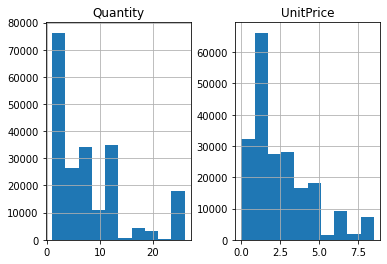

In [11]:
df[["Quantity", "UnitPrice"]].hist()
plt.show()

## Calculate RFM values

In [12]:
df["TotalEarningPerItem"] = df["Quantity"] * df["UnitPrice"]
RFM_df = (
    df.groupby("CustomerID")
    .agg({"InvoiceDate": "max", "InvoiceNo": "nunique", "TotalEarningPerItem": "mean"})
    .reset_index()
    .rename(
        columns={
            "InvoiceDate": "LastPurchaseDate",
            "InvoiceNo": "Frequency",
            "TotalEarningPerItem": "Monetary",
        }
    )
)

RFM_df["LastPurchaseDate"] = (pd.Timestamp.now() - RFM_df["LastPurchaseDate"]).dt.days
RFM_df.rename(columns={"LastPurchaseDate": "Recency"}, inplace=True)
RFM_df

,CustomerID,Recency,Frequency,Monetary
0,12347,3734,7,22.064455
1,12348,3980,3,16.866667
2,12349,3750,1,18.759189
3,12350,4042,1,16.775000
4,12352,3768,7,17.239231
...,...,...,...,...
4192,18280,4009,1,18.285714
4193,18281,3912,1,12.280000
4194,18282,3739,2,14.141250
4195,18283,3735,16,3.558675


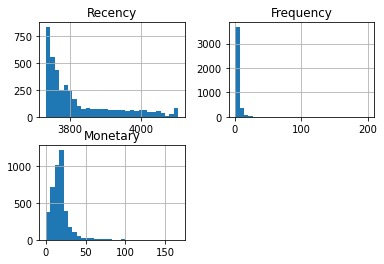

In [13]:
RFM_df.hist(bins=30)
plt.show()

# Clustering

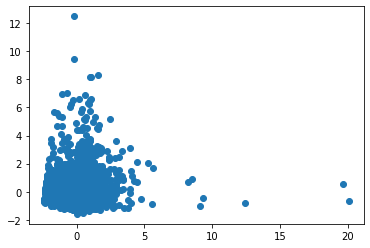

In [14]:
RFM_values = make_pipeline(StandardScaler(), PCA(n_components=2)).fit_transform(
    RFM_df[["Recency", "Frequency", "Monetary"]]
)
plt.scatter(
    x=RFM_values[:, 0],
    y=RFM_values[:, 1],
)
plt.show()

## K-means

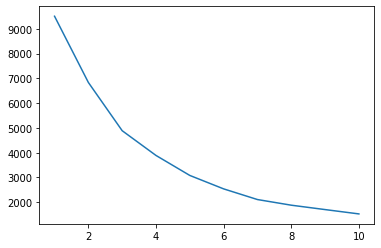

In [15]:
inertias = [
    KMeans(n_clusters=k, random_state=0).fit(RFM_values).inertia_ for k in range(1, 11)
]
plt.plot(range(1, 11), inertias)
plt.show()

In [16]:
best_k = max(
    {
        k: silhouette_score(
            RFM_values, KMeans(n_clusters=k, random_state=0).fit(RFM_values).labels_
        )
        for k in range(5, 8)
    }
)
best_k

7

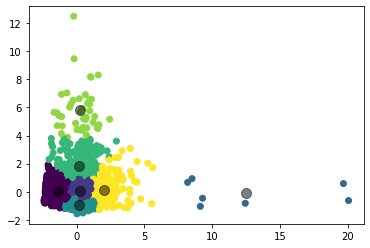

In [17]:
kmeans_model = KMeans(best_k, random_state=0).fit(RFM_values)
plt.scatter(
    RFM_values[:, 0],
    RFM_values[:, 1],
    c=kmeans_model.labels_,
)
plt.scatter(
    kmeans_model.cluster_centers_[:, 0],
    kmeans_model.cluster_centers_[:, 1],
    c="black",
    s=100,
    alpha=0.5,
)
plt.show()

## DBSCAN

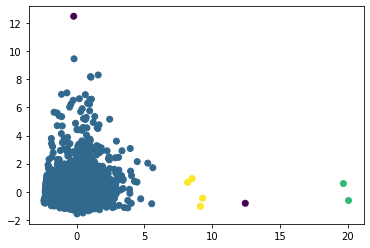

In [18]:
plt.scatter(
    RFM_values[:, 0],
    RFM_values[:, 1],
    c=DBSCAN(eps=2, min_samples=2).fit(RFM_values).labels_,
)
plt.show()

## Agglomerative Clustering With Ward Linkage

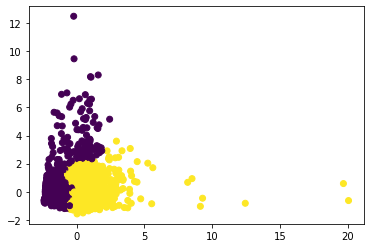

In [20]:
plt.scatter(
    RFM_values[:, 0],
    RFM_values[:, 1],
    c=AgglomerativeClustering().fit(RFM_values).labels_,
)
plt.show()